In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_brk'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.49107142857142855 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8880208333333334
FEMALE 0.11 

GLOBAL: 0.5088383838383839 

Using scikit learn accuracy por género en el conjunto to
MALE 0.9002433090024331
FEMALE 0.08661417322834646 

GLOBAL: 0.5019556714471969 

Using scikit learn accuracy por género en el conjunto as
MALE 0.9040404040404041
FEMALE 0.07277628032345014 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6871810578303055 	 Validation loss: 0.6859560760401063 	 
  1%|          | 574/57400 [00:07<12:09, 77.92it/s]
Epoch 2 	 Training loss: 0.6837044425750028 	 Validation loss: 0.6845455391932342 	 
  2%|▏         | 1148/57400 [00:15<11:26, 81.94it/s]
Epoch 3 	 Training loss: 0.6822812715058543 	 Validation loss: 0.6840644721257485 	 
  3%|▎         | 1722/57400 [00:23<11:28, 80.86it/s]
Epoch 4 	 Training loss: 0.6818145454345265 	 Validation loss: 0.6839262489545144 	 
  4%|▍         | 2296/57400 [00:30<11:15, 81.60it/s]
Epoch 5 	 Training loss: 0.6815956674178718 	 Validation loss: 0.6840008426520784 	 
  5%|▌         | 2870/57400 [00:38<11:45, 77.26it/s]
Epoch 6 	 Training loss: 0.6815574390339935 	 Validation loss: 0.6840599664187027 	 
  6%|▌         | 3444/57400 [00:46<12:22, 72.62it/s]
Epoch 7 	 Training loss: 0.6814926801450577 	 Validation loss: 0.6841362886509653 	 
  7%|▋         | 4018/57400 [00:54<10:41, 83.20it/s]
Epoch 8 	 Training loss: 0.68157172

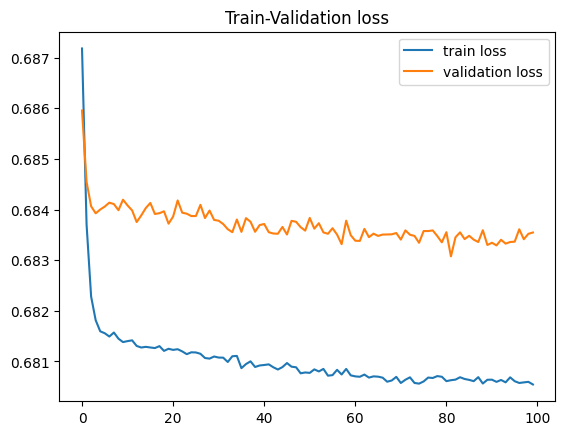

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_brk'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934297432675179 	 Validation loss: 0.6943747532569756 	 
  1%|          | 574/57400 [00:09<13:08, 72.04it/s]
Epoch 2 	 Training loss: 0.6933282756016229 	 Validation loss: 0.6935468174643435 	 
  2%|▏         | 1148/57400 [00:17<13:31, 69.32it/s]
Epoch 3 	 Training loss: 0.6931871086462865 	 Validation loss: 0.6933048034118394 	 
  3%|▎         | 1722/57400 [00:27<15:00, 61.81it/s]
Epoch 4 	 Training loss: 0.6932032474865066 	 Validation loss: 0.6933472974825714 	 
  4%|▍         | 2296/57400 [00:36<14:49, 61.98it/s]
Epoch 5 	 Training loss: 0.6933005920478276 	 Validation loss: 0.6932443875377461 	 
  5%|▌         | 2870/57400 [00:46<14:04, 64.56it/s]
Epoch 6 	 Training loss: 0.6931955186124462 	 Validation loss: 0.6932373511589179 	 
  6%|▌         | 3444/57400 [00:56<14:20, 62.67it/s]
Epoch 7 	 Training loss: 0.6932152272932205 	 Validation loss: 0.6931488736201141 	 
  7%|▋         | 4018/57400 [01:06<14:55, 59.63it/s]
Epoch 8 	 Training loss: 0.69322200

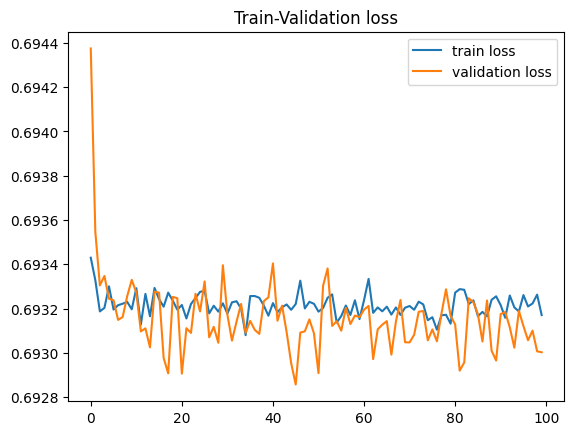

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4961734693877551 

Using scikit learn accuracy por género en el conjunto about
MALE 0.3489583333333333
FEMALE 0.6375 

GLOBAL: 0.4911616161616162 

Using scikit learn accuracy por género en el conjunto to
MALE 0.35766423357664234
FEMALE 0.6351706036745407 

GLOBAL: 0.529335071707953 

Using scikit learn accuracy por género en el conjunto as
MALE 0.37373737373737376
FEMALE 0.6954177897574124 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_brk'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933860747656341 	 Validation loss: 0.6934387047412032 	 
  1%|          | 574/57400 [00:05<08:11, 115.55it/s]
Epoch 2 	 Training loss: 0.6933042152625758 	 Validation loss: 0.6930961578579272 	 
  2%|▏         | 1148/57400 [00:10<08:06, 115.65it/s]
Epoch 3 	 Training loss: 0.6932758251756741 	 Validation loss: 0.6933187256425114 	 
  3%|▎         | 1722/57400 [00:16<07:44, 119.91it/s]
Epoch 4 	 Training loss: 0.693293919442838 	 Validation loss: 0.6929287920563908 	 
  4%|▍         | 2296/57400 [00:21<07:53, 116.31it/s]
Epoch 5 	 Training loss: 0.6932911661028447 	 Validation loss: 0.6929457642264285 	 
  5%|▌         | 2870/57400 [00:26<07:54, 114.88it/s]
Epoch 6 	 Training loss: 0.6932626788209124 	 Validation loss: 0.6930066761323961 	 
  6%|▌         | 3444/57400 [00:32<07:49, 114.99it/s]
Epoch 7 	 Training loss: 0.6933074138721107 	 Validation loss: 0.6929730722459696 	 
  7%|▋         | 4018/57400 [00:37<07:45, 114.79it/s]
Epoch 8 	 Training loss: 0.69

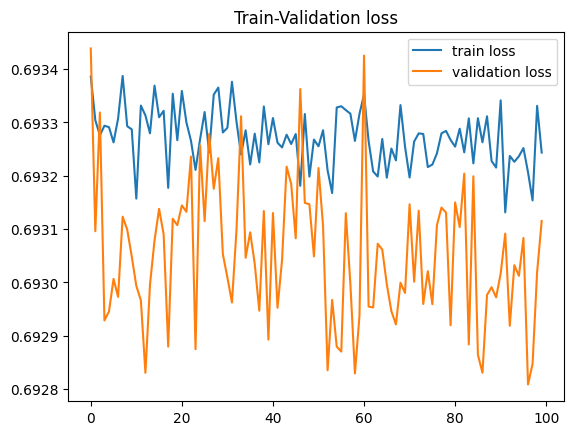

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.49362244897959184 

Using scikit learn accuracy por género en el conjunto about
MALE 0.1640625
FEMALE 0.81 

GLOBAL: 0.4734848484848485 

Using scikit learn accuracy por género en el conjunto to
MALE 0.20437956204379562
FEMALE 0.7637795275590551 

GLOBAL: 0.47327249022164275 

Using scikit learn accuracy por género en el conjunto as
MALE 0.1717171717171717
FEMALE 0.7951482479784366 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_brk_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6807984390948292 	 Validation loss: 0.6809351818036224 	 
  1%|          | 574/57400 [00:05<08:15, 114.79it/s]
Epoch 2 	 Training loss: 0.6701042922116323 	 Validation loss: 0.6631148184760142 	 
  2%|▏         | 1148/57400 [00:10<08:13, 113.95it/s]
Epoch 3 	 Training loss: 0.6564855035589132 	 Validation loss: 0.6571095414080862 	 
  3%|▎         | 1722/57400 [00:16<08:16, 112.15it/s]
Epoch 4 	 Training loss: 0.6490738383568954 	 Validation loss: 0.654563886634374 	 
  4%|▍         | 2296/57400 [00:21<08:23, 109.47it/s]
Epoch 5 	 Training loss: 0.6423230211701543 	 Validation loss: 0.6475196642390753 	 
  5%|▌         | 2870/57400 [00:27<08:09, 111.38it/s]
Epoch 6 	 Training loss: 0.6361336708068848 	 Validation loss: 0.6423495826074632 	 
  6%|▌         | 3444/57400 [00:32<07:49, 114.81it/s]
Epoch 7 	 Training loss: 0.6303408919518833 	 Validation loss: 0.6369679125688844 	 
  7%|▋         | 4018/57400 [00:38<07:54, 112.60it/s]
Epoch 8 	 Training loss: 0.62

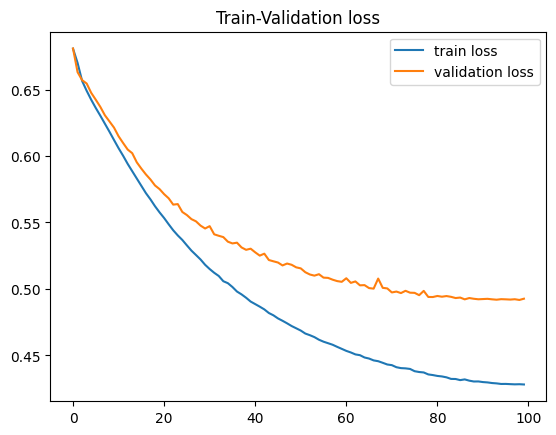

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7028061224489796 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8541666666666666
FEMALE 0.5575 

GLOBAL: 0.5782828282828283 

Using scikit learn accuracy por género en el conjunto to
MALE 0.708029197080292
FEMALE 0.43832020997375326 

GLOBAL: 0.5788787483702738 

Using scikit learn accuracy por género en el conjunto as
MALE 0.696969696969697
FEMALE 0.4528301886792453 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_brk_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933262466553611 	 Validation loss: 0.6939201506517702 	 
  1%|          | 574/57400 [00:06<09:19, 101.56it/s]
Epoch 2 	 Training loss: 0.6931905444283103 	 Validation loss: 0.6934051251007338 	 
  2%|▏         | 1148/57400 [00:12<09:08, 102.57it/s]
Epoch 3 	 Training loss: 0.6931585083855154 	 Validation loss: 0.692751425807759 	 
  3%|▎         | 1722/57400 [00:18<08:59, 103.21it/s]
Epoch 4 	 Training loss: 0.693163086624511 	 Validation loss: 0.6928575685468771 	 
  4%|▍         | 2296/57400 [00:24<08:48, 104.23it/s]
Epoch 5 	 Training loss: 0.6930120230136433 	 Validation loss: 0.6926722021426185 	 
  5%|▌         | 2870/57400 [00:30<09:04, 100.13it/s]
Epoch 6 	 Training loss: 0.6930443444110791 	 Validation loss: 0.6933569574760179 	 
  6%|▌         | 3444/57400 [00:36<08:50, 101.70it/s]
Epoch 7 	 Training loss: 0.6930523729698168 	 Validation loss: 0.6936639820115041 	 
  7%|▋         | 4018/57400 [00:42<08:43, 101.89it/s]
Epoch 8 	 Training loss: 0.692

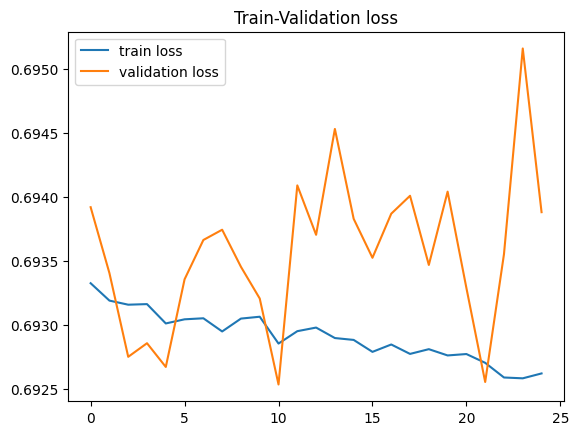

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5165816326530612 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0859375
FEMALE 0.93 

GLOBAL: 0.4621212121212121 

Using scikit learn accuracy por género en el conjunto to
MALE 0.06569343065693431
FEMALE 0.889763779527559 

GLOBAL: 0.4771838331160365 

Using scikit learn accuracy por género en el conjunto as
MALE 0.08080808080808081
FEMALE 0.9002695417789758 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_brk_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693238182454159 	 Validation loss: 0.6921883154723604 	 
  1%|          | 574/57400 [00:06<09:02, 104.77it/s]
Epoch 2 	 Training loss: 0.69320549917138 	 Validation loss: 0.6931075170888739 	 
  2%|▏         | 1148/57400 [00:12<09:11, 101.98it/s]
Epoch 3 	 Training loss: 0.6930575503704856 	 Validation loss: 0.6930443664728585 	 
  3%|▎         | 1722/57400 [00:17<08:49, 105.19it/s]
Epoch 4 	 Training loss: 0.6929102245108176 	 Validation loss: 0.6916952052358853 	 
  4%|▍         | 2296/57400 [00:23<08:42, 105.47it/s]
Epoch 5 	 Training loss: 0.6929735237090014 	 Validation loss: 0.6925513219025176 	 
  5%|▌         | 2870/57400 [00:29<08:50, 102.86it/s]
Epoch 6 	 Training loss: 0.6929541427499326 	 Validation loss: 0.6928973854598353 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:35<08:36, 104.49it/s]
Epoch 7 	 Training loss: 0.6930066670067219 	 Validation loss: 0.6924496838601969 	 
  7%|▋         | 4018/57400 [00:41<08:35, 103.65it/s]
Ep

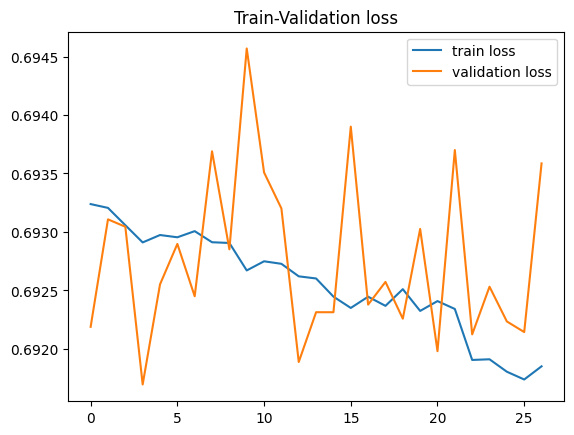

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5089285714285714 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 0.9975 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.485006518904824 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0025252525252525255
FEMALE 1.0 

